In [42]:

## Imports

import imageio
from matplotlib import pyplot as plt
import numpy as np
import os

from sklearn import decomposition as sklearn_decomposition


In [43]:

"""Constants."""

_SESSION = '2022-06-01'
_TIMESTEPRANGE = (0, 200)
_TITLE = _SESSION + '/stimulus_delay_good_1_obj'
_CONDITIONS = ((0,), (1,), (2,))
# _CONDITIONS = ((0, 1), (1, 2), (0, 2))
_DATASET = 'data/stimulus_delay_good_units'

_PALETTE = {
    0: (1, 0, 0),
    1: (0, 1, 0),
    2: (0, 0, 1),
    (0,): (1, 0, 0),
    (1,): (0, 1, 0),
    (2,): (0, 0, 1),
    (0, 1): (0.7, 0.7, 0),
    (0, 2): (0.7, 0, 0.7),
    (1, 2): (0, 0.7, 0.7),
    (0, 1, 2): (0.5, 0.5, 0.5),
    
    ((0, 1), 0): (1., 0.7, 0),
    ((0, 1), 1): (0.7, 1., 0),
    ((0, 2), 0): (1., 0, 0.7),
    ((0, 2), 2): (0.7, 0, 1.),
    ((1, 2), 1): (0, 1., 0.7),
    ((1, 2), 2): (0, 0.7, 1.),
}


In [44]:


class GifWriter(object):
    """GifWriter class."""

    def __init__(self,
                 gif_file,
                 duration=0.3,
                 duration_last=None,
                 duration_first=None):
        """Constructor.

        Args:
            gif_file: String. Full path to gif filename. Should end in '.gif'.
            duration: Int. Frames per second for the gif.
        """
        
        if duration_last is None:
            duration_last = duration
        self._duration_last = duration_last
        if duration_first is None:
            duration_first = duration
        self._duration_first = duration_first
        self._duration = duration

        # If the gif directory does not exist, ask the user if they want to
        # create it.
        gif_file = os.path.expanduser(gif_file)
        gif_dir = os.path.dirname(gif_file)
        if not os.path.exists(gif_dir):
            print('Directory {} does not exist'.format(gif_dir))
            should_create = input(
                'Would you like to create that directory?  (y/n)')
            if should_create == 'y':
                print('Creating directory {}'.format(gif_dir))
                os.makedirs(gif_dir)
            else:
                print('exiting')
                sys.exit()

        # If the gif directory already exists, ask the user if they want to
        # override it.
        if os.path.isfile(gif_file):
            print('File {} to write gif to already exists.'.format(gif_file))
            should_override = input(
                'Would you like to override the file there?  (y/n)')
            if should_override == 'y':
                print('Removing {}'.format(gif_file))
                os.remove(gif_file)
            else:
                print('exiting')
                sys.exit()
                
        self._gif_file = gif_file
        self._images = []

    def add(self, image):
        self._images.append(image)

    def close(self):
        """Write the gif."""
        print('Writing gif with {} images to file {}'.format(
            len(self._images), self._gif_file))
        duration = len(self._images) * [self._duration]
        duration[0] = self._duration_first
        duration[-1] = self._duration_last
        imageio.mimsave(self._gif_file, self._images, duration=duration, loop=0)
        


In [45]:
"""Read data."""

read_dir = os.path.join(_DATASET, _SESSION)

neural = []
for unit in os.listdir(read_dir):
    data = np.load(os.path.join(read_dir, unit), allow_pickle=True).item()

    unit_neural = []
    for k, v in data.items():
        if k in _CONDITIONS:
            unit_neural.append(v[_TIMESTEPRANGE[0]: _TIMESTEPRANGE[1]])
    neural.append(unit_neural)
        
neural = np.array(neural)
neural = np.transpose(neural, axes=(1, 2, 0))
print(f'neural.shape = {neural.shape}')

neural.shape = (3, 200, 106)


In [46]:
"""PCA transform neural data"""

def write_to_gif(name, fig, ax):
    gif_name = name + '.gif'
    gif_file = os.path.join(os.getcwd(), 'gifs', gif_name)
    gif_writer = gif_writer_lib.GifWriter(gif_file=gif_file, duration=50)

    # Rotate plot and save frames to gif_writer
    frames = []
    for angle in range(0, 360, 5):
        ax.view_init(30, angle)
        # Must scatter something to trigger re-rendering, so scatter zero-size
        # point.
        ax.scatter([0], [0], [0], s=0)
        fig.canvas.draw()
        plt.pause(.001)
        frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(frame)

    frames = np.array(frames)
    frames_white = frames == 255
    frames_x_white = np.prod(frames_white, axis=(0, 2, 3))
    frames_y_white = np.prod(frames_white, axis=(0, 1, 3))
    x_min = np.min(np.argwhere(frames_x_white == 0)) - 1
    x_max = np.max(np.argwhere(frames_x_white == 0)) + 1
    y_min = np.min(np.argwhere(frames_y_white == 0)) - 1
    y_max = np.max(np.argwhere(frames_y_white == 0)) + 1
    cropped_frames = frames[:, x_min: x_max, y_min: y_max]

    for frame in cropped_frames:
        gif_writer.add(frame)
    gif_writer.close()
    

def get_pca(neural, n_components=10):
    neural = np.copy(neural)
    neural -= np.mean(neural, axis=0, keepdims=True)

    pca_fit = sklearn_decomposition.PCA(n_components=n_components).fit(
        neural)
    scree = np.cumsum(pca_fit.explained_variance_ratio_)
    print(scree)
    neural_pca = pca_fit.transform(neural)
    return neural_pca, n_components


neural_shape = neural.shape
neural_flat = np.reshape(neural, (-1, neural_shape[-1]))
neural_pca_flat, n_components = get_pca(neural_flat)
neural_pca = np.reshape(
    neural_pca_flat, list(neural_shape)[:-1] + [n_components])

print(f'neural_pca.shape = {neural_pca.shape}')

[0.42483635 0.61515115 0.72899502 0.81464234 0.86956643 0.89542819
 0.91576415 0.93121291 0.94361087 0.95292967]
neural_pca.shape = (3, 200, 10)


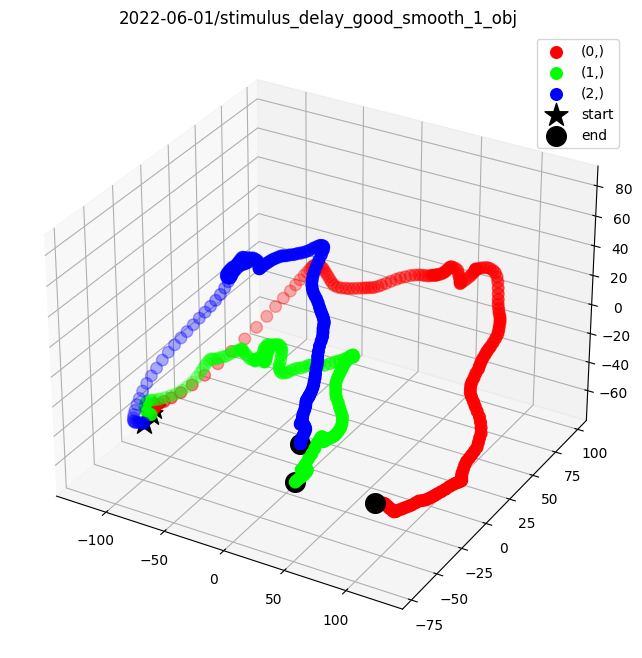

In [47]:
"""Plot PCA."""

pca_indices = [0, 1, 2]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
for cond, cond_data in zip(_CONDITIONS, neural_pca):
    x = cond_data[:, pca_indices[0]]
    y = cond_data[:, pca_indices[1]]
    z = cond_data[:, pca_indices[2]]
    ax.scatter(
        x, y, z, color=_PALETTE[cond], s=70, label=cond,
    )
    
    # Plot start and end points
    start_label = 'start' if cond == _CONDITIONS[-1] else None
    ax.scatter(
        x[0], y[0], z[0], color='k', marker='*', s=300, label=start_label)
    end_label = 'end' if cond == _CONDITIONS[-1] else None
    ax.scatter(
        x[-1], y[-1], z[-1], color='k', marker='o', s=200, label=end_label)
    
ax.legend()
ax.set_title(_TITLE)
plt.show()

In [48]:
write_to_gif(_TITLE, fig, ax)

File /Users/nicholaswatters/Desktop/grad_school/research/mehrdad/albert_qin/pca/gifs/2022-06-01/stimulus_delay_good_smooth_1_obj.gif to write gif to already exists.
Removing /Users/nicholaswatters/Desktop/grad_school/research/mehrdad/albert_qin/pca/gifs/2022-06-01/stimulus_delay_good_smooth_1_obj.gif
Writing gif with 72 images to file /Users/nicholaswatters/Desktop/grad_school/research/mehrdad/albert_qin/pca/gifs/2022-06-01/stimulus_delay_good_smooth_1_obj.gif
